<a target="_blank" href="https://colab.research.google.com/github/Melon-Quest/CloudMask/blob/main/notebooks/preprocessing_s1_s2_images.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 00- How to use the notebook

## User Credentials


To run this notebook you need to enter your personal credentials:

**GEE_PROJECT_ID**: Your GEE project id inside Google Cloud. To create a project follow this tutorial: https://youtu.be/fiqeSRzG_8k?si=82ZIZsOUv4pEfSdK

**BASE_PATH**: The base path to the data.


In [ ]:
GEE_PROJECT_ID = ""

BASE_PATH = ""

# 01- Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import geemap
import ee
import os
import rasterio
import time
from skimage.util import img_as_float
from matplotlib import pyplot as plt
import random
import folium
import tensorflow as tf
import math
import geemap.colormaps as cm

# Authenticate and initialize Google Earth Engine API
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT_ID)

# 02- Utils


In [ ]:
def get_s2_col(aoi, start_date, end_date, S2_COLLECTION_ID):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection(S2_COLLECTION_ID)
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    return s2_sr_col


# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

def display_mosaic(col_list, AOI):

    # Create a folium map object.
    center = AOI.centroid(10).coordinates().reverse().getInfo()
    m = folium.Map(location=center, zoom_start=12)

    for i in range(len(col_list)):

        # Mosaic the image collection.
        img = col_list[i].mosaic().clip(AOI)

        # Add layers to the folium map.
        m.add_ee_layer(img,
                    {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                    f'S2 image {i}', i==0, 1, 9)

    # Add a layer control panel to the map.
    m.add_child(folium.LayerControl())

    # Display the map.
    display(m)

# 03- Load Data

In [ ]:
coordernates = (-5.18804, -37.3441)

Map = geemap.Map()

Map = geemap.Map(center=coordernates, zoom=12)

Map.add_basemap("HYBRID")
Map

Map(center=[-5.18804, -37.3441], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [ ]:
# Get the figure from the interactive map
region = Map.user_roi
Map.addLayer(region, {},"AOI")

centroid = region.centroid(1)

bounds = region.bounds(1)

coords = bounds.coordinates().get(0).getInfo()

centroid_lon = centroid.coordinates().get(0).getInfo()

west = ee.Geometry.Rectangle([coords[0][0], coords[0][1], centroid_lon, coords[2][1]])  # Adjusted coordinates
east = ee.Geometry.Rectangle([centroid_lon, coords[0][1], coords[2][0], coords[2][1]])  # Adjusted coordinates

west = region.intersection(west,1)
east = region.intersection(east,1)

Map.addLayer(west, {}, "West")
Map.addLayer(east, {}, "East")

Map

Map(bottom=538839.0, center=[-4.886757077044932, -37.34529112527862], controls=(WidgetControl(options=['positi…

In [ ]:
region = Map.user_roi
region.area(1).divide(1e4)

In [ ]:
# VALIDATION

coordernates = (-5.18804, -37.3441)

validation_map = geemap.Map()

validation_map = geemap.Map(center=coordernates, zoom=12)

validation_map.add_basemap("HYBRID")
validation_map

Map(center=[-5.18804, -37.3441], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [ ]:
validation_region = Map.user_roi

In [ ]:
# Training AOI
if (region):
  train_aoi = east
else:
    train_aoi = ee.Geometry.Polygon(
          [[[-47.36729325776277,-22.921012287966867],
            [-47.28017510895906,-22.921012287966867],
            [-47.28017510895906,-22.820260456811546],
            [-47.36729325776277,-22.820260456811546],
            [-47.36729325776277,-22.921012287966867],],
          [[-47.28017510895906,-22.921012287966867],
            [-47.193056960155346,-22.921012287966867],
            [-47.193056960155346,-22.820260456811546],
            [-47.28017510895906,-22.820260456811546],
            [-47.28017510895906,-22.921012287966867],]])

# Testing AOI
if (region):
  test_aoi = west
else:
  test_aoi = ee.Geometry.Polygon(
          [[[-47.367134932338416,-22.972493612961138],
            [-47.19375694161576,-22.972493612961138],
            [-47.19375694161576,-22.9217509095172],
            [-47.367134932338416,-22.9217509095172],
            [-47.367134932338416,-22.972493612961138],]])

# Validation AOI
validation_aoi = validation_region

## Sentinel-2 collection

In [ ]:
# DATE_LIST = [
#     ["2024-01-01", "2024-01-08"],
#     ["2024-01-09", "2024-01-16"],
#     ["2024-01-17", "2024-01-24"],
#     ["2024-01-25", "2024-02-01"],
#     ["2024-02-01", "2024-02-08"],
#     ["2024-02-09", "2024-02-16"],
#     ["2024-02-17", "2024-02-24"],
#     ["2024-02-25", "2024-03-01"],
#     ["2024-03-01", "2024-03-08"],
#     ["2024-03-09", "2024-03-16"],
#     ["2024-03-17", "2024-03-24"],
#     ["2024-03-25", "2024-04-01"],
#     ["2024-04-01", "2024-04-08"],
#     ["2024-04-09", "2024-04-16"],
#     ["2024-04-17", "2024-04-24"],
#     ["2024-04-25", "2024-05-01"],
# ]

DATE_LIST = [
    ["2024-01-02", "2024-01-16"],
    ["2024-01-17", "2024-02-01"],
    ["2024-02-02", "2024-02-16"],
    ["2024-02-17", "2024-03-01"],
    ["2024-03-02", "2024-03-16"],
    ["2024-03-17", "2024-04-01"],
    ["2024-04-02", "2024-04-16"],
    ["2024-04-17", "2024-05-01"],
    ["2024-05-02", "2024-05-16"],
    ["2024-05-17", "2024-06-01"],
    ["2024-06-02", "2024-06-16"],
    ["2024-06-17", "2024-07-01"],
]

S2_COLLECTION_ID = "COPERNICUS/S2_SR_HARMONIZED"

# integer Maximum image cloud cover percent allowed in image collection
CLOUD_FILTER = 60

### Train

In [ ]:
train_s2_col_list = []

for date in DATE_LIST:
    s2_col = get_s2_col(train_aoi, date[0], date[1], S2_COLLECTION_ID)
    train_s2_col_list.append(s2_col)

print(f"Number of collections : {len(train_s2_col_list)}")

Number of collections : 12


In [ ]:
display_mosaic(train_s2_col_list, train_aoi)

### Test

In [ ]:
test_s2_col_list = []

for date in DATE_LIST:
    s2_col = get_s2_col(test_aoi, date[0], date[1], S2_COLLECTION_ID)
    test_s2_col_list.append(s2_col)

print(f"Number of collections : {len(test_s2_col_list)}")

Number of collections : 12


In [ ]:
display_mosaic(test_s2_col_list, test_aoi)

### Validation

In [ ]:
val_s2_col_list = []

for date in DATE_LIST:
    s2_col = get_s2_col(validation_aoi, date[0], date[1], S2_COLLECTION_ID)
    val_s2_col_list.append(s2_col)

print(f"Number of collections : {len(val_s2_col_list)}")

Number of collections : 12


In [ ]:
display_mosaic(val_s2_col_list, validation_aoi)

## Sentinel-1 Synthetic Aperture Radar (SAR) collection

In [ ]:
S1_COLLECTION_ID = "COPERNICUS/S1_GRD"

Code made by Mullissa, A.; Vollrath, A.; Odongo-Braun, C.; Slagter, B.; Balling, J.; Gou, Y.; Gorelick, N.; Reiche, J. Sentinel-1 SAR Backscatter Analysis Ready Data Preparation in Google Earth Engine. Remote Sens. 2021, 13, 1954. https://doi.org/10.3390/rs13101954

### Terrain Flatening

In [ ]:
# ---------------------------------------------------------------------------//
# Terrain Flattening
# ---------------------------------------------------------------------------//

def slope_correction(collection, TERRAIN_FLATTENING_MODEL
                                 ,DEM, TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER):
    """

    Parameters
    ----------
    collection : ee image collection
        DESCRIPTION.
    TERRAIN_FLATTENING_MODEL : string
        The radiometric terrain normalization model, either volume or direct
    DEM : ee asset
        The DEM to be used
    TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER : integer
        The additional buffer to account for the passive layover and shadow

    Returns
    -------
    ee image collection
        An image collection where radiometric terrain normalization is
        implemented on each image

    """

    ninetyRad = ee.Image.constant(90).multiply(math.pi/180)

    def _volumetric_model_SCF(theta_iRad, alpha_rRad):
        """

        Parameters
        ----------
        theta_iRad : ee.Image
            The scene incidence angle
        alpha_rRad : ee.Image
            Slope steepness in range

        Returns
        -------
        ee.Image
            Applies the volume model in the radiometric terrain normalization

        """

        # Volume model
        nominator = (ninetyRad.subtract(theta_iRad).add(alpha_rRad)).tan()
        denominator = (ninetyRad.subtract(theta_iRad)).tan()
        return nominator.divide(denominator)

    def _direct_model_SCF(theta_iRad, alpha_rRad, alpha_azRad):
        """

        Parameters
        ----------
        theta_iRad : ee.Image
            The scene incidence angle
        alpha_rRad : ee.Image
            Slope steepness in range

        Returns
        -------
        ee.Image
            Applies the direct model in the radiometric terrain normalization

        """
        # Surface model
        nominator = (ninetyRad.subtract(theta_iRad)).cos()
        denominator = alpha_azRad.cos().multiply((ninetyRad.subtract(theta_iRad).add(alpha_rRad)).cos())
        return nominator.divide(denominator)

    def _erode(image, distance):
        """


        Parameters
        ----------
        image : ee.Image
            Image to apply the erode function to
        distance : integer
            The distance to apply the buffer

        Returns
        -------
        ee.Image
            An image that is masked to conpensate for passive layover
            and shadow depending on the given distance

        """
        # buffer function (thanks Noel)

        d = (image.Not().unmask(1).fastDistanceTransform(30).sqrt()
             .multiply(ee.Image.pixelArea().sqrt()))

        return image.updateMask(d.gt(distance))

    def _masking(alpha_rRad, theta_iRad, buffer):
        """

        Parameters
        ----------
        alpha_rRad : ee.Image
            Slope steepness in range
        theta_iRad : ee.Image
            The scene incidence angle
        buffer : TYPE
            DESCRIPTION.

        Returns
        -------
        ee.Image
            An image that is masked to conpensate for passive layover
            and shadow depending on the given distance

        """
        # calculate masks
        # layover, where slope > radar viewing angle
        layover = alpha_rRad.lt(theta_iRad).rename('layover')
        # shadow
        shadow = alpha_rRad.gt(ee.Image.constant(-1)
                        .multiply(ninetyRad.subtract(theta_iRad))).rename('shadow')
        # combine layover and shadow
        mask = layover.And(shadow)
        # add buffer to final mask
        if (buffer > 0):
            mask = _erode(mask, buffer)
        return mask.rename('no_data_mask')

    def _correct(image):
        """


        Parameters
        ----------
        image : ee.Image
            Image to apply the radiometric terrain normalization to

        Returns
        -------
        ee.Image
            Radiometrically terrain corrected image

        """

        bandNames = image.bandNames()

        geom = image.geometry()
        proj = image.select(1).projection()

        elevation = DEM.resample('bilinear').reproject(proj,None, 10).clip(geom)

        # calculate the look direction
        heading = ee.Terrain.aspect(image.select('angle')).reduceRegion(ee.Reducer.mean(), image.geometry(), 1000)


        #in case of null values for heading replace with 0
        heading = ee.Dictionary(heading).combine({'aspect': 0}, False).get('aspect')

        heading = ee.Algorithms.If(
            ee.Number(heading).gt(180),
            ee.Number(heading).subtract(360),
            ee.Number(heading)
        )

        # the numbering follows the article chapters
        # 2.1.1 Radar geometry
        theta_iRad = image.select('angle').multiply(math.pi/180)
        phi_iRad = ee.Image.constant(heading).multiply(math.pi/180)

        # 2.1.2 Terrain geometry
        alpha_sRad = ee.Terrain.slope(elevation).select('slope').multiply(math.pi / 180)

        aspect = ee.Terrain.aspect(elevation).select('aspect').clip(geom)

        aspect_minus = aspect.updateMask(aspect.gt(180)).subtract(360)

        phi_sRad = aspect.updateMask(aspect.lte(180))\
            .unmask()\
            .add(aspect_minus.unmask())\
            .multiply(-1)\
            .multiply(math.pi / 180)

        #elevation = DEM.reproject(proj,None, 10).clip(geom)

        # 2.1.3 Model geometry
        # reduce to 3 angle
        phi_rRad = phi_iRad.subtract(phi_sRad)

        # slope steepness in range (eq. 2)
        alpha_rRad = (alpha_sRad.tan().multiply(phi_rRad.cos())).atan()

        # slope steepness in azimuth (eq 3)
        alpha_azRad = (alpha_sRad.tan().multiply(phi_rRad.sin())).atan()

        # 2.2
        # Gamma_nought
        gamma0 = image.divide(theta_iRad.cos())

        if (TERRAIN_FLATTENING_MODEL == 'VOLUME'):
            # Volumetric Model
            scf = _volumetric_model_SCF(theta_iRad, alpha_rRad)

        if (TERRAIN_FLATTENING_MODEL == 'DIRECT'):
            scf = _direct_model_SCF(theta_iRad, alpha_rRad, alpha_azRad)

        # apply model for Gamm0
        gamma0_flat = gamma0.multiply(scf)

        # get Layover/Shadow mask
        mask = _masking(alpha_rRad, theta_iRad, TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER)
        output = gamma0_flat.mask(mask).rename(bandNames).copyProperties(image)
        output = ee.Image(output).addBands(image.select('angle'), None, True)

        return output.set('system:time_start', image.get('system:time_start'))
    return collection.map(_correct)

### Speckle filters

In [ ]:
# ---------------------------------------------------------------------------//
# 1.SPECKLE FILTERS
# ---------------------------------------------------------------------------//

def boxcar(image, KERNEL_SIZE):
    """
    Apply boxcar filter on every image in the collection.

    Parameters
    ----------
    image : ee.Image
        Image to be filtered
    KERNEL_SIZE : positive odd integer
        Neighbourhood window size

    Returns
    -------
    ee.Image
        Filtered Image

    """
    bandNames = image.bandNames().remove('angle')
      #Define a boxcar kernel
    kernel = ee.Kernel.square((KERNEL_SIZE/2), units='pixels', normalize=True)
     #Apply boxcar
    output = image.select(bandNames).convolve(kernel).rename(bandNames)
    return image.addBands(output, None, True)

def leefilter(image, KERNEL_SIZE):
    """
    Lee Filter applied to one image.
    It is implemented as described in
    J. S. Lee, “Digital image enhancement and noise filtering by use of local statistics,”
    IEEE Pattern Anal. Machine Intell., vol. PAMI-2, pp. 165–168, Mar. 1980.

    Parameters
    ----------
    image : ee.Image
        Image to be filtered
    KERNEL_SIZE : positive odd integer
        Neighbourhood window size

    Returns
    -------
    ee.Image
        Filtered Image

    """
    bandNames = image.bandNames().remove('angle')

    # S1-GRD images are multilooked 5 times in range
    enl = 5
    # Compute the speckle standard deviation
    eta = 1.0/math.sqrt(enl)
    eta = ee.Image.constant(eta)

    # MMSE estimator
    # Neighbourhood mean and variance
    oneImg = ee.Image.constant(1)
    # Estimate stats
    reducers = ee.Reducer.mean().combine(
                      reducer2= ee.Reducer.variance()
                      ,sharedInputs= True
                      )
    stats = (image.select(bandNames).reduceNeighborhood(
                      reducer= reducers
                          ,kernel= ee.Kernel.square(KERNEL_SIZE/2, 'pixels')
                              ,optimization= 'window'))
    meanBand = bandNames.map(lambda bandName: ee.String(bandName).cat('_mean'))
    varBand = bandNames.map(lambda bandName:  ee.String(bandName).cat('_variance'))

    z_bar = stats.select(meanBand)
    varz = stats.select(varBand)
    # Estimate weight
    varx = (varz.subtract(z_bar.pow(2).multiply(eta.pow(2)))).divide(oneImg.add(eta.pow(2)))
    b = varx.divide(varz)

    # if b is negative set it to zero
    new_b = b.where(b.lt(0), 0)
    output = oneImg.subtract(new_b).multiply(z_bar.abs()).add(new_b.multiply(image.select(bandNames)))
    output = output.rename(bandNames)
    return image.addBands(output, None, True)


def gammamap(image,KERNEL_SIZE):

    """
    Gamma Maximum a-posterior Filter applied to one image. It is implemented as described in
    Lopes A., Nezry, E., Touzi, R., and Laur, H., 1990.
    Maximum A Posteriori Speckle Filtering and First Order texture Models in SAR Images.
    International  Geoscience  and  Remote  Sensing  Symposium (IGARSS).
    Parameters
    ----------
    image : ee.Image
        Image to be filtered
    KERNEL_SIZE : positive odd integer
        Neighbourhood window size
    Returns
    -------
    ee.Image
        Filtered Image
    """
    enl = 5
    bandNames = image.bandNames().remove('angle')
    #local mean
    reducers = ee.Reducer.mean().combine( \
                      reducer2= ee.Reducer.stdDev(), \
                      sharedInputs= True
                      )
    stats = (image.select(bandNames).reduceNeighborhood( \
                      reducer= reducers, \
                          kernel= ee.Kernel.square(KERNEL_SIZE/2,'pixels'), \
                              optimization= 'window'))
    meanBand = bandNames.map(lambda bandName: ee.String(bandName).cat('_mean'))
    stdDevBand = bandNames.map(lambda bandName:  ee.String(bandName).cat('_stdDev'))

    z = stats.select(meanBand)
    sigz = stats.select(stdDevBand)

    #local observed coefficient of variation
    ci = sigz.divide(z)
    #noise coefficient of variation (or noise sigma)
    cu = 1.0/math.sqrt(enl)
    #threshold for the observed coefficient of variation
    cmax = math.sqrt(2.0) * cu
    cu = ee.Image.constant(cu)
    cmax = ee.Image.constant(cmax)
    enlImg = ee.Image.constant(enl)
    oneImg = ee.Image.constant(1)
    twoImg = ee.Image.constant(2)

    alpha = oneImg.add(cu.pow(2)).divide(ci.pow(2).subtract(cu.pow(2)))

    #Implements the Gamma MAP filter described in equation 11 in Lopez et al. 1990
    q = image.select(bandNames).expression('z**2 * (z * alpha - enl - 1)**2 + 4 * alpha * enl * b() * z', { 'z': z,  'alpha':alpha,'enl': enl})
    rHat = z.multiply(alpha.subtract(enlImg).subtract(oneImg)).add(q.sqrt()).divide(twoImg.multiply(alpha))

    #if ci <= cu then its a homogenous region ->> boxcar filter
    zHat = (z.updateMask(ci.lte(cu))).rename(bandNames)
    #if cmax > ci > cu then its a textured medium ->> apply Gamma MAP filter
    rHat = (rHat.updateMask(ci.gt(cu)).updateMask(ci.lt(cmax))).rename(bandNames)
    #ci>cmax then its strong signal ->> retain
    x = image.select(bandNames).updateMask(ci.gte(cmax)).rename(bandNames)
    #Merge
    output = ee.ImageCollection([zHat,rHat,x]).sum()
    return image.addBands(output, None, True)

def RefinedLee(image):
    """
    This filter is modified from the implementation by Guido Lemoine
    Source: Lemoine et al. https://code.earthengine.google.com/5d1ed0a0f0417f098fdfd2fa137c3d0c

    Parameters
    ----------
    image: ee.Image
        Image to be filtered

    Returns
    -------
    result: ee.Image
        Filtered Image

    """

    bandNames = image.bandNames().remove('angle')

    def inner(b):

        img = image.select([b]);

        # img must be linear, i.e. not in dB!
        # Set up 3x3 kernels
        weights3 = ee.List.repeat(ee.List.repeat(1,3),3);
        kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False);

        mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3);
        variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3);

        # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
        sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]]);

        sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False);

        # Calculate mean and variance for the sampled windows and store as 9 bands
        sample_mean = mean3.neighborhoodToBands(sample_kernel);
        sample_var = variance3.neighborhoodToBands(sample_kernel);

        # Determine the 4 gradients for the sampled windows
        gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs();
        gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs());
        gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs());
        gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs());

        # And find the maximum gradient amongst gradient bands
        max_gradient = gradients.reduce(ee.Reducer.max());

        # Create a mask for band pixels that are the maximum gradient
        gradmask = gradients.eq(max_gradient);

        # duplicate gradmask bands: each gradient represents 2 directions
        gradmask = gradmask.addBands(gradmask);

        # Determine the 8 directions
        directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1);
        directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2));
        directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3));
        directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4));
        # The next 4 are the not() of the previous 4
        directions = directions.addBands(directions.select(0).Not().multiply(5));
        directions = directions.addBands(directions.select(1).Not().multiply(6));
        directions = directions.addBands(directions.select(2).Not().multiply(7));
        directions = directions.addBands(directions.select(3).Not().multiply(8));

        # Mask all values that are not 1-8
        directions = directions.updateMask(gradmask);

        # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
        directions = directions.reduce(ee.Reducer.sum());

        sample_stats = sample_var.divide(sample_mean.multiply(sample_mean));

        #Calculate localNoiseVariance
        sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0]);

        # Set up the 7*7 kernels for directional statistics
        rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4));

        diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]]);

        rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False);
        diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False);

        # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
        dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1));
        dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1));

        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)));
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)));

        # and add the bands for rotated kernels
        for i in range(1, 4):
            dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
            dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))


        # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
        dir_mean = dir_mean.reduce(ee.Reducer.sum());
        dir_var = dir_var.reduce(ee.Reducer.sum());

        # A finally generate the filtered value
        varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))

        b = varX.divide(dir_var)
        result = dir_mean.add(b.multiply(img.subtract(dir_mean)))

        return result.arrayProject([0]).arrayFlatten([['sum']]).float()

    result = ee.ImageCollection(bandNames.map(inner)).toBands().rename(bandNames).copyProperties(image)

    return image.addBands(result, None, True)



def leesigma(image,KERNEL_SIZE):
    """
    Implements the improved lee sigma filter to one image.
    It is implemented as described in, Lee, J.-S. Wen, J.-H. Ainsworth, T.L. Chen, K.-S. Chen, A.J.
    Improved sigma filter for speckle filtering of SAR imagery.
    IEEE Trans. Geosci. Remote Sens. 2009, 47, 202–213.

    Parameters
    ----------
    image : ee.Image
        Image to be filtered
    KERNEL_SIZE : positive odd integer
        Neighbourhood window size

    Returns
    -------
    ee.Image
        Filtered Image

    """

    #parameters
    Tk = ee.Image.constant(7) #number of bright pixels in a 3x3 window
    sigma = 0.9
    enl = 4
    target_kernel = 3
    bandNames = image.bandNames().remove('angle')

    #compute the 98 percentile intensity
    z98 = ee.Dictionary(image.select(bandNames).reduceRegion(
                reducer= ee.Reducer.percentile([98]),
                geometry= image.geometry(),
                scale=10,
                maxPixels=1e13
            )).toImage()


    #select the strong scatterers to retain
    brightPixel = image.select(bandNames).gte(z98)
    K = brightPixel.reduceNeighborhood(ee.Reducer.countDistinctNonNull()
            ,ee.Kernel.square(target_kernel/2))
    retainPixel = K.gte(Tk)


    #compute the a-priori mean within a 3x3 local window
    #original noise standard deviation since the data is 5 look
    eta = 1.0/math.sqrt(enl)
    eta = ee.Image.constant(eta)
    #MMSE applied to estimate the apriori mean
    reducers = ee.Reducer.mean().combine( \
                      reducer2= ee.Reducer.variance(), \
                      sharedInputs= True
                      )
    stats = image.select(bandNames).reduceNeighborhood( \
                      reducer= reducers, \
                          kernel= ee.Kernel.square(target_kernel/2,'pixels'), \
                              optimization= 'window')
    meanBand = bandNames.map(lambda bandName: ee.String(bandName).cat('_mean'))
    varBand = bandNames.map(lambda bandName:  ee.String(bandName).cat('_variance'))

    z_bar = stats.select(meanBand)
    varz = stats.select(varBand)

    oneImg = ee.Image.constant(1)
    varx = (varz.subtract(z_bar.abs().pow(2).multiply(eta.pow(2)))).divide(oneImg.add(eta.pow(2)))
    b = varx.divide(varz)
    xTilde = oneImg.subtract(b).multiply(z_bar.abs()).add(b.multiply(image.select(bandNames)))

    #step 3: compute the sigma range
    #Lookup table (J.S.Lee et al 2009) for range and eta values for intensity (only 4 look is shown here)
    LUT = ee.Dictionary({0.5: ee.Dictionary({'I1': 0.694,'I2': 1.385,'eta': 0.1921}),
                                 0.6: ee.Dictionary({'I1': 0.630,'I2': 1.495,'eta': 0.2348}),
                                 0.7: ee.Dictionary({'I1': 0.560,'I2': 1.627,'eta': 0.2825}),
                                 0.8: ee.Dictionary({'I1': 0.480,'I2': 1.804,'eta': 0.3354}),
                                 0.9: ee.Dictionary({'I1': 0.378,'I2': 2.094,'eta': 0.3991}),
                                 0.95: ee.Dictionary({'I1': 0.302,'I2': 2.360,'eta': 0.4391})});

    #extract data from lookup
    sigmaImage = ee.Dictionary(LUT.get(str(sigma))).toImage()
    I1 = sigmaImage.select('I1')
    I2 = sigmaImage.select('I2')
    #new speckle sigma
    nEta = sigmaImage.select('eta')
    #establish the sigma ranges
    I1 = I1.multiply(xTilde)
    I2 = I2.multiply(xTilde)

    #step 3: apply MMSE filter for pixels in the sigma range
    #MMSE estimator
    mask = image.select(bandNames).gte(I1).Or(image.select(bandNames).lte(I2))
    z = image.select(bandNames).updateMask(mask)

    stats = z.reduceNeighborhood( \
                      reducer= reducers, \
                          kernel= ee.Kernel.square(KERNEL_SIZE/2,'pixels'), \
                              optimization= 'window')

    z_bar = stats.select(meanBand)
    varz = stats.select(varBand)


    varx = (varz.subtract(z_bar.abs().pow(2).multiply(nEta.pow(2)))).divide(oneImg.add(nEta.pow(2)))
    b = varx.divide(varz)
    #if b is negative set it to zero
    new_b = b.where(b.lt(0), 0)
    xHat = oneImg.subtract(new_b).multiply(z_bar.abs()).add(new_b.multiply(z))

    #remove the applied masks and merge the retained pixels and the filtered pixels
    xHat = image.select(bandNames).updateMask(retainPixel).unmask(xHat)
    output = ee.Image(xHat).rename(bandNames)
    return image.addBands(output, None, True)


#---------------------------------------------------------------------------//
# 2. MONO-TEMPORAL SPECKLE FILTER (WRAPPER)
#---------------------------------------------------------------------------//


def MonoTemporal_Filter(coll,KERNEL_SIZE, SPECKLE_FILTER) :
    """
    A wrapper function for monotemporal filter

    Parameters
    ----------
    coll : ee Image collection
        the image collection to be filtered
    KERNEL_SIZE : odd integer
        Spatial Neighbourhood window
    SPECKLE_FILTER : String
        Type of speckle filter

    Returns
    -------
    ee.ImageCollection
        An image collection where a mono-temporal filter is applied to each
        image individually

    """
    def _filter(image):
       if (SPECKLE_FILTER=='BOXCAR'):
          _filtered = boxcar(image, KERNEL_SIZE)
       elif (SPECKLE_FILTER=='LEE'):
          _filtered = leefilter(image, KERNEL_SIZE)
       elif (SPECKLE_FILTER=='GAMMA MAP'):
          _filtered = gammamap(image, KERNEL_SIZE)
       elif (SPECKLE_FILTER=='REFINED LEE'):
          _filtered = RefinedLee(image)
       elif (SPECKLE_FILTER=='LEE SIGMA'):
          _filtered = leesigma(image, KERNEL_SIZE)
       return _filtered
    return coll.map(_filter)

# ---------------------------------------------------------------------------//
# 3. MULTI-TEMPORAL SPECKLE FILTER
# ---------------------------------------------------------------------------//

def MultiTemporal_Filter(coll,KERNEL_SIZE, SPECKLE_FILTER,NR_OF_IMAGES):
    """

    A wrapper function for multi-temporal filter

    Parameters
    ----------
    coll : ee Image collection
        the image collection to be filtered
    KERNEL_SIZE : odd integer
        Spatial Neighbourhood window
    SPECKLE_FILTER : String
        Type of speckle filter
    NR_OF_IMAGES : positive integer
        Number of images to use in multi-temporal filtering

    Returns
    -------
    ee.ImageCollection
        An image collection where a multi-temporal filter is applied to each
        image individually

    """

    def Quegan(image) :
        """
        The following Multi-temporal speckle filters are implemented as described in
        S. Quegan and J. J. Yu, “Filtering of multichannel SAR images,”
        IEEE Trans Geosci. Remote Sensing, vol. 39, Nov. 2001.

        this function will filter the collection used for the multi-temporal part
        it takes care of:
        - same image geometry (i.e relative orbit)
        - full overlap of image
        - amount of images taken for filtering
            -- all before
           -- if not enough, images taken after the image to filter are added

        Parameters
        ----------
        image : ee.Image
            Image to be filtered

        Returns
        -------
        ee.Image
            Filtered image

        """
        def setresample(image):
                return image.resample()

        def get_filtered_collection(image):
            """
            Generate a dedicated image collection

            Parameters
            ----------
            image : ee.Image
                Image whose geometry is used to define the new collection

            Returns
            -------
            ee Image collection

            """

            #filter collection over are and by relative orbit
            s1_coll = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
                .filterBounds(image.geometry()) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', ee.List(image.get('transmitterReceiverPolarisation')).get(-1))) \
                .filter(ee.Filter.Or(ee.Filter.eq('relativeOrbitNumber_stop', image.get('relativeOrbitNumber_stop')), \
                                     ee.Filter.eq('relativeOrbitNumber_stop', image.get('relativeOrbitNumber_start'))
                )).map(setresample)

            #a function that takes the image and checks for the overlap
            def check_overlap(_image):
                """
                get all S1 frames from this date intersecting with the image bounds

                Parameters
                ----------
                _image : ee.Image
                    Image to check the overlap with

                Returns
                -------
                ee Image Collection
                    A collection with matching geometry

                """

                # get all S1 frames from this date intersecting with the image bounds
                s1 = s1_coll.filterDate(_image.date(), _image.date().advance(1, 'day'))
                # intersect those images with the image to filter
                intersect = image.geometry().intersection(s1.geometry().dissolve(), 10)
                # check if intersect is sufficient
                valid_date = ee.Algorithms.If(intersect.area(10).divide(image.geometry().area(10)).gt(0.95), \
                                              _image.date().format('YYYY-MM-dd')
                                              )
                return ee.Feature(None, {'date': valid_date})


            # this function will pick up the acq dates for fully overlapping acquisitions before the image acquistion
            dates_before = s1_coll.filterDate('2014-01-01', image.date().advance(1, 'day')) \
                                    .sort('system:time_start', False).limit(5*NR_OF_IMAGES) \
                                    .map(check_overlap).distinct('date').aggregate_array('date')

            # if the images before are not enough, we add images from after the image acquisition
            # this will only be the case at the beginning of S1 mission
            dates = ee.List(ee.Algorithms.If( \
                                             dates_before.size().gte(NR_OF_IMAGES), \
                                                 dates_before.slice(0, NR_OF_IMAGES), \
                                                     s1_coll \
                                                         .filterDate(image.date(), '2100-01-01') \
                                                             .sort('system:time_start', True).limit(5*NR_OF_IMAGES) \
                                                                 .map(check_overlap) \
                                                                     .distinct('date') \
                                                                         .aggregate_array('date') \
                                                                             .cat(dates_before).distinct().sort().slice(0, NR_OF_IMAGES)
                                                                             )
                                                )

            #now we re-filter the collection to get the right acquisitions for multi-temporal filtering
            return ee.ImageCollection(dates.map(lambda date: s1_coll.filterDate(date, ee.Date(date).advance(1,'day')).toList(s1_coll.size())).flatten())



        #we get our dedicated image collection for that image
        s1 = get_filtered_collection(image)

        bands = image.bandNames().remove('angle')
        s1 = s1.select(bands)
        meanBands = bands.map(lambda bandName: ee.String(bandName).cat('_mean'))
        ratioBands = bands.map(lambda bandName: ee.String(bandName).cat('_ratio'))
        count_img = s1.reduce(ee.Reducer.count())

        def inner(image):
            """
            Creats an image whose bands are the filtered image and image ratio

            Parameters
            ----------
            image : ee.Image
                Image to be filtered

            Returns
            -------
            ee.Image
                Filtered image and image ratio

            """
            if (SPECKLE_FILTER=='BOXCAR'):
                _filtered = boxcar(image, KERNEL_SIZE).select(bands).rename(meanBands)
            elif (SPECKLE_FILTER=='LEE'):
                _filtered = leefilter(image, KERNEL_SIZE).select(bands).rename(meanBands)
            elif (SPECKLE_FILTER=='GAMMA MAP'):
                _filtered = gammamap(image, KERNEL_SIZE).select(bands).rename(meanBands)
            elif (SPECKLE_FILTER=='REFINED LEE'):
                _filtered = RefinedLee(image).select(bands).rename(meanBands)
            elif (SPECKLE_FILTER=='LEE SIGMA'):
                _filtered = leesigma(image, KERNEL_SIZE).select(bands).rename(meanBands)

            _ratio = image.select(bands).divide(_filtered).rename(ratioBands)
            return _filtered.addBands(_ratio)

        isum = s1.map(inner).select(ratioBands).reduce(ee.Reducer.sum())
        filtered = inner(image).select(meanBands)
        divide = filtered.divide(count_img)
        output = divide.multiply(isum).rename(bands)

        return image.addBands(output, None, True)
    return coll.map(Quegan)

### Wrapper

In [ ]:
def s1_preproc(params):
    """
    Applies preprocessing to a collection of S1 images to return an analysis ready sentinel-1 data.

    Parameters
    ----------
    params : Dictionary
        These parameters determine the data selection and image processing parameters.

    Raises
    ------
    ValueError


    Returns
    -------
    ee.ImageCollection
        A processed Sentinel-1 image collection

    """


    APPLY_BORDER_NOISE_CORRECTION = params['APPLY_BORDER_NOISE_CORRECTION']
    APPLY_TERRAIN_FLATTENING = params['APPLY_TERRAIN_FLATTENING']
    APPLY_SPECKLE_FILTERING = params['APPLY_SPECKLE_FILTERING']
    POLARIZATION = params['POLARIZATION']
    ORBIT = params['ORBIT']
    SPECKLE_FILTER_FRAMEWORK = params['SPECKLE_FILTER_FRAMEWORK']
    SPECKLE_FILTER = params['SPECKLE_FILTER']
    SPECKLE_FILTER_KERNEL_SIZE = params['SPECKLE_FILTER_KERNEL_SIZE']
    SPECKLE_FILTER_NR_OF_IMAGES = params['SPECKLE_FILTER_NR_OF_IMAGES']
    TERRAIN_FLATTENING_MODEL = params['TERRAIN_FLATTENING_MODEL']
    DEM = params['DEM']
    TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER = params['TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER']
    FORMAT = params['FORMAT']
    START_DATE = params['START_DATE']
    STOP_DATE = params['STOP_DATE']
    ROI = params['ROI']
    CLIP_TO_ROI = params['CLIP_TO_ROI']
    SAVE_ASSET = params['SAVE_ASSET']
    ASSET_ID = params['ASSET_ID']

    ###########################################
    # 0. CHECK PARAMETERS
    ###########################################

    if APPLY_BORDER_NOISE_CORRECTION is None:
        APPLY_BORDER_NOISE_CORRECTION = True
    if APPLY_TERRAIN_FLATTENING is None:
        APPLY_TERRAIN_FLATTENING = True
    if APPLY_SPECKLE_FILTERING is None:
        APPLY_SPECKLE_FILTERING = True
    if POLARIZATION is None:
        POLARIZATION = 'VVVH'
    if ORBIT is None:
        ORBIT = 'BOTH'
    if SPECKLE_FILTER_FRAMEWORK is None:
        SPECKLE_FILTER_FRAMEWORK = 'MULTI BOXCAR'
    if SPECKLE_FILTER is None:
        SPECKLE_FILTER = 'GAMMA MAP'
    if SPECKLE_FILTER_KERNEL_SIZE is None:
        SPECKLE_FILTER_KERNEL_SIZE = 7
    if SPECKLE_FILTER_NR_OF_IMAGES is None:
        SPECKLE_FILTER_NR_OF_IMAGES = 10
    if TERRAIN_FLATTENING_MODEL is None:
        TERRAIN_FLATTENING_MODEL = 'VOLUME'
    if TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER is None:
        TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER = 0
    if FORMAT is None:
        FORMAT = 'DB'
    if ORBIT is None:
        ORBIT = 'DESCENDING'

    pol_required = ['VV', 'VH', 'VVVH']
    if (POLARIZATION not in pol_required):
        raise ValueError("ERROR!!! Parameter POLARIZATION not correctly defined")

    orbit_required = ['ASCENDING', 'DESCENDING', 'BOTH']
    if (ORBIT not in orbit_required):
        raise ValueError("ERROR!!! Parameter ORBIT not correctly defined")

    model_required = ['DIRECT', 'VOLUME']
    if (TERRAIN_FLATTENING_MODEL not in model_required):
        raise ValueError("ERROR!!! Parameter TERRAIN_FLATTENING_MODEL not correctly defined")

    format_required = ['LINEAR', 'DB']
    if (FORMAT not in format_required):
        raise ValueError("ERROR!!! FORMAT not correctly defined")

    frame_needed = ['MONO', 'MULTI']
    if (SPECKLE_FILTER_FRAMEWORK not in frame_needed):
        raise ValueError("ERROR!!! SPECKLE_FILTER_FRAMEWORK not correctly defined")

    format_sfilter = ['BOXCAR', 'LEE', 'GAMMA MAP'
              ,'REFINED LEE', 'LEE SIGMA']
    if (SPECKLE_FILTER not in format_sfilter):
        raise ValueError("ERROR!!! SPECKLE_FILTER not correctly defined")

    if (TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER < 0):
        raise ValueError("ERROR!!! TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER not correctly defined")

    if (SPECKLE_FILTER_KERNEL_SIZE <= 0):
        raise ValueError("ERROR!!! SPECKLE_FILTER_KERNEL_SIZE not correctly defined")

    ###########################################
    # 1. DATA SELECTION
    ###########################################

    # select S-1 image collection
    s1 = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
        .filterDate(START_DATE, STOP_DATE) \
        .filterBounds(ROI)


    # select orbit
    if (ORBIT != 'BOTH'):
        s1 = s1.filter(ee.Filter.eq('orbitProperties_pass', ORBIT))

    # select polarization
    if (POLARIZATION == 'VV'):
        s1 = s1.select(['VV', 'angle'])
    elif (POLARIZATION == 'VH'):
        s1 = s1.select(['VH', 'angle'])
    elif (POLARIZATION == 'VVVH'):
        s1 = s1.select(['VV', 'VH', 'angle'])

    print('Number of images in collection: ', s1.size().getInfo())

    ###########################################
    # 2. ADDITIONAL BORDER NOISE CORRECTION
    ###########################################

    if (APPLY_BORDER_NOISE_CORRECTION):
        s1_1 = s1.map(f_mask_edges)
        print('Additional border noise correction is completed')
    else:
        s1_1 = s1
    ########################
    # 3. SPECKLE FILTERING
    #######################

    if (APPLY_SPECKLE_FILTERING):
        if (SPECKLE_FILTER_FRAMEWORK == 'MONO'):
            s1_1 = ee.ImageCollection(MonoTemporal_Filter(s1_1, SPECKLE_FILTER_KERNEL_SIZE, SPECKLE_FILTER))
            print('Mono-temporal speckle filtering is completed')
        else:
            s1_1 = ee.ImageCollection(MultiTemporal_Filter(s1_1, SPECKLE_FILTER_KERNEL_SIZE, SPECKLE_FILTER, SPECKLE_FILTER_NR_OF_IMAGES))
            print('Multi-temporal speckle filtering is completed')

    ########################
    # 4. TERRAIN CORRECTION
    #######################

    if (APPLY_TERRAIN_FLATTENING):
        s1_1 = (slope_correction(s1_1
                                    ,TERRAIN_FLATTENING_MODEL
                                        ,DEM
                                                ,TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER))
        print('Radiometric terrain normalization is completed')

    ########################
    # 5. OUTPUT
    #######################

    if (FORMAT == 'DB'):
        s1_1 = s1_1.map(lin_to_db)


    #clip to roi
    if (CLIP_TO_ROI):
        s1 = s1.map(lambda image: image.clip(ROI))
        s1_1 = s1_1.map(lambda image: image.clip(ROI))


    if (SAVE_ASSET):

        size = s1_1.size().getInfo()
        imlist = s1_1.toList(size)
        for idx in range(0, size):
            img = imlist.get(idx)
            img = ee.Image(img)
            name = str(img.id().getInfo())
            #name = str(idx)
            description = name
            assetId = ASSET_ID+'/'+name

            task = ee.batch.Export.image.toAsset(image=img,
                                                 assetId=assetId,
                                                 description=description,
                                                 region=s1_1.geometry(),
                                                 scale=10,
                                                 maxPixels=1e13)
            task.start()
            print('Exporting {} to {}'.format(name, assetId))
    return [s1, s1_1]

### Border noise correction

In [ ]:
# ---------------------------------------------------------------------------//
# Additional Border Noise Removal
# ---------------------------------------------------------------------------//


def maskAngLT452(image):
    """
    mask out angles >= 45.23993

    Parameters
    ----------
    image : ee.Image
        image to apply the border noise masking

    Returns
    -------
    ee.Image
        Masked image

    """
    ang = image.select(['angle'])
    return image.updateMask(ang.lt(45.23993)).set('system:time_start', image.get('system:time_start'))



def maskAngGT30(image):
    """
    mask out angles <= 30.63993

    Parameters
    ----------
    image : ee.Image
        image to apply the border noise masking

    Returns
    -------
    ee.Image
        Masked image

    """

    ang = image.select(['angle'])
    return image.updateMask(ang.gt(30.63993)).set('system:time_start', image.get('system:time_start'))


def maskEdge(image):
    """
    Remove edges.

    Parameters
    ----------
    image : ee.Image
        image to apply the border noise masking

    Returns
    -------
    ee.Image
        Masked image

    """

    mask = image.select(0).unitScale(-25, 5).multiply(255).toByte()#.connectedComponents(ee.Kernel.rectangle(1,1), 100)
    return image.updateMask(mask.select(0)).set('system:time_start', image.get('system:time_start'))



def f_mask_edges(image):
    """
    Function to mask out border noise artefacts

    Parameters
    ----------
    image : ee.Image
        image to apply the border noise correction to

    Returns
    -------
    ee.Image
        Corrected image

    """

    db_img = lin_to_db(image)
    output = maskAngGT30(db_img)
    output = maskAngLT452(output)
    #output = maskEdge(output)
    output = db_to_lin(output)
    return output.set('system:time_start', image.get('system:time_start'))

### Helper

In [ ]:
# ---------------------------------------------------------------------------//
# Linear to db scale
# ---------------------------------------------------------------------------//

def lin_to_db(image):
    """
    Convert backscatter from linear to dB.

    Parameters
    ----------
    image : ee.Image
        Image to convert

    Returns
    -------
    ee.Image
        output image

    """
    bandNames = image.bandNames().remove('angle')
    db = ee.Image.constant(10).multiply(image.select(bandNames).log10()).rename(bandNames)
    return image.addBands(db, None, True)


def db_to_lin(image):
    """
    Convert backscatter from dB to linear.

    Parameters
    ----------
    image : ee.Image
        Image to convert

    Returns
    -------
    ee.Image
        output image

    """
    bandNames = image.bandNames().remove('angle')
    lin = ee.Image.constant(10).pow(image.select(bandNames).divide(10)).rename(bandNames)
    return image.addBands(lin, None, True)

def lin_to_db2(image):
    """
    Convert backscatter from linear to dB by removing the ratio band.

    Parameters
    ----------
    image : ee.Image
        Image to convert

    Returns
    -------
    ee.Image
        Converted image

    """
    db = ee.Image.constant(10).multiply(image.select(['VV', 'VH']).log10()).rename(['VV', 'VH'])
    return image.addBands(db, None, True)

# ---------------------------------------------------------------------------//
# Add ratio bands
# ---------------------------------------------------------------------------//

def add_ratio_lin(image):
    """
    Adding ratio band for visualization

    Parameters
    ----------
    image : ee.Image
        Image to use for creating band ratio

    Returns
    -------
    ee.Image
        Image containing the ratio band

    """
    ratio = image.addBands(image.select('VV').divide(image.select('VH')).rename('VVVH_ratio'))

    return ratio.set('system:time_start', image.get('system:time_start'))

### Main

In [ ]:
"""
    Parameter:
        START_DATE: The earliest date to include images for (inclusive).
        END_DATE: The latest date to include images for (exclusive).
        POLARIZATION: The Sentinel-1 image polarization to select for processing.
            'VV' - selects the VV polarization.
            'VH' - selects the VH polarization.
            "VVVH' - selects both the VV and VH polarization for processing.
        ORBIT:  The orbits to include. (string: BOTH, ASCENDING or DESCENDING)
        GEOMETRY: The region to include imagery within.
                  The user can interactively draw a bounding box within the map window or define the edge coordinates.
        APPLY_BORDER_NOISE_CORRECTION: (Optional) true or false options to apply additional Border noise correction:
        APPLY_SPECKLE_FILTERING: (Optional) true or false options to apply speckle filter
        SPECKLE_FILTER: Type of speckle filtering to apply (String). If the APPLY_SPECKLE_FILTERING parameter is true then the selected speckle filter type will be used.
            'BOXCAR' - Applies a boxcar filter on each individual image in the collection
            'LEE' - Applies a Lee filter on each individual image in the collection based on [1]
            'GAMMA MAP' - Applies a Gamma maximum a-posterior speckle filter on each individual image in the collection based on [2] & [3]
            'REFINED LEE' - Applies the Refined Lee speckle filter on each individual image in the collection
                                  based on [4]
            'LEE SIGMA' - Applies the improved Lee sigma speckle filter on each individual image in the collection
                                  based on [5]
        SPECKLE_FILTER_FRAMEWORK: is the framework where filtering is applied (String). It can be 'MONO' or 'MULTI'. In the MONO case
                                  the filtering is applied to each image in the collection individually. Whereas, in the MULTI case,
                                  the Multitemporal Speckle filter is applied based on  [6] with any of the above mentioned speckle filters.
        SPECKLE_FILTER_KERNEL_SIZE: is the size of the filter spatial window applied in speckle filtering. It must be a positive odd integer.
        SPECKLE_FILTER_NR_OF_IMAGES: is the number of images to use in the multi-temporal speckle filter framework. All images are selected before the date of image to be filtered.
                                    However, if there are not enough images before it then images after the date are selected.
        TERRAIN_FLATTENING : (Optional) true or false option to apply Terrain correction based on [7] & [8].
        TERRAIN_FLATTENING_MODEL : model to use for radiometric terrain normalization (DIRECT, or VOLUME)
        DEM : digital elevation model (DEM) to use (as EE asset)
        TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER : additional buffer parameter for passive layover/shadow mask in meters
        FORMAT : the output format for the processed collection. this can be 'LINEAR' or 'DB'.
        CLIP_TO_ROI: (Optional) Clip the processed image to the region of interest.
        SAVE_ASSETS : (Optional) Exports the processed collection to an asset.
        ASSET_ID : (Optional) The user id path to save the assets

    Returns:
        An ee.ImageCollection with an analysis ready Sentinel 1 imagery with the specified polarization images and angle band.
    """
#/***************************/
#// MAIN
#/***************************/
#Parameters
parameter = {  'START_DATE': '2016-06-23',
            'STOP_DATE': '2020-02-01',
            'POLARIZATION': 'VVVH',
            'ORBIT' : 'BOTH',
            'ROI': train_aoi,
            'APPLY_BORDER_NOISE_CORRECTION': True,
            'APPLY_SPECKLE_FILTERING': True,
            'SPECKLE_FILTER_FRAMEWORK':'MULTI',
            'SPECKLE_FILTER': 'BOXCAR',
            'SPECKLE_FILTER_KERNEL_SIZE': 10,
            'SPECKLE_FILTER_NR_OF_IMAGES':15,
            'APPLY_TERRAIN_FLATTENING': True,
            'DEM': ee.Image('USGS/SRTMGL1_003'),
            'TERRAIN_FLATTENING_MODEL': 'VOLUME',
            'TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER':0,
            'FORMAT': 'DB',
            'CLIP_TO_ROI': True,
            'SAVE_ASSET': False,
            'ASSET_ID': "",
            'FOLDER_NAME': "s1_data"
            }
#processed s1 collection
s1_processed = s1_preproc(parameter)

s1 = s1_processed[0]
s1_processed = s1_processed[1]

Number of images in collection:  104
Additional border noise correction is completed
Multi-temporal speckle filtering is completed
Radiometric terrain normalization is completed


In [ ]:
s1_len = s1_processed.size().getInfo()
type(s1_len)

int

In [ ]:
visparam = {}
if (parameter["POLARIZATION"]=='VVVH'):
    if (parameter["FORMAT"]=='DB'):
        s1_view = s1.map(add_ratio_lin).map(lin_to_db2)
        s1_processed_view = s1_processed.map(add_ratio_lin).map(lin_to_db2)
        visparam = {"bands":['VV','VH','VVVH_ratio'],"min": [-20, -25, 1],"max": [0, -5, 15]}

    else:
        s1_processed_view = s1_processed.map(add_ratio_lin)
        s1_view = s1.map(add_ratio_lin)
        visparam = {"bands":['VV','VH','VVVH_ratio'], "min": [0.01, 0.0032, 1.25],"max": [1, 0.31, 31.62]}

else:
    if (parameter["FORMAT"]=='DB'):
        s1_processed_view = s1_processed.map(lin_to_db)
        s1_view = s1.map(lin_to_db)
        visparam = {"bands":[parameter["POLARIZATION"]],"min": -25,"max": 0}

    else:
        s1_processed_view = s1_processed
        s1_view = s1
        visparam = {"bands":[parameter["POLARIZATION"]],"min": 0,"max": 0.2}

print(visparam)
center = train_aoi.centroid(10).coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start = 12)

m.add_ee_layer(
    s1_view.first(), visparam, "First image in the input S1 collection", False
)

m.add_ee_layer(
    s1_processed_view.first(), visparam, "First image in the processed S1 collection", True
)

m.add_ee_layer(
    train_s2_col_list[0].mosaic().clip(train_aoi),
                    {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                    f'S2 image', False, 1, 9
)

m.add_child(folium.LayerControl())

display(m)

{'bands': ['VV', 'VH', 'VVVH_ratio'], 'min': [-20, -25, 1], 'max': [0, -5, 15]}


In [ ]:
s1.first()

In [ ]:
display_mosaic(test_s2_col_list, test_aoi)

## Export Images to drive

### S2 Training Set

In [ ]:
train_s2_col_list[0].getInfo()["id"]

'COPERNICUS/S2_SR_HARMONIZED'

In [ ]:
# EXPORT S2 IMAGES
for i in range(len(train_s2_col_list)):

    # Mosaic the image collection.
    s2_image = train_s2_col_list[i].mosaic().clip(train_aoi)
    task = ee.batch.Export.image.toDrive(image = s2_image.select(['B2', 'B3', 'B4']),
                                        region = train_aoi,
                                        description = f"s2_image_{i}",
                                        folder= 's2_train',
                                        fileNamePrefix=f"s2_image_{i}",
                                        scale=10,
                                        maxPixels=1e13,
                                        crs='EPSG:4326')
    # Start Download
    task.start()

### S2 Testing Set

In [ ]:
# EXPORT S2 IMAGES
for i in range(len(test_s2_col_list)):

    # Mosaic the image collection.
    s2_image = test_s2_col_list[i].mosaic().clip(test_aoi)
    task = ee.batch.Export.image.toDrive(image = s2_image.select(['B2', 'B3', 'B4']),
                                        region = train_aoi,
                                        description = f"s2_image_{i}",
                                        folder= 's2_test',
                                        fileNamePrefix=f"s2_image_{i}",
                                        scale=10,
                                        maxPixels=1e13,
                                        crs='EPSG:4326')
    # Start Download
    task.start()

### S2 Validation Set

In [ ]:
# EXPORT S2 IMAGES
for i in range(len(val_s2_col_list)):

    # Mosaic the image collection.
    s2_image = val_s2_col_list[i].mosaic().clip(test_aoi)
    task = ee.batch.Export.image.toDrive(image = s2_image.select(['B2', 'B3', 'B4']),
                                        region = train_aoi,
                                        description = f"s2_image_{i}",
                                        folder= 's2_validation',
                                        fileNamePrefix= f"s2_image_{i}",
                                        scale=10,
                                        maxPixels=1e13,
                                        crs='EPSG:4326')
    # Start Download
    task.start()

## Import Dataset

### Train S2

In [ ]:
train_images = []
for i in range(len(train_s2_col_list)):
    train_aoi_path = BASE_PATH + f"/s2_train/s2_image_train_{i}.tif"

    src = rasterio.open(
        train_aoi_path,
        mode = 'r',
        driver = 'GTiff',
        count = None,
        crs = 'EPSG:4326',
        transform = None,
        dtype = 'float32',
    )

    im = src.read()
    im = im.transpose([1,2,0])
    im = (im/10000)*255
    img = im.astype('uint8')

    rgb = np.dstack((img[:,:,2], img[:,:,1], img[:,:,0]))
    img_rgb = img_as_float(rgb)
    img_rgb = np.nan_to_num(img_rgb) # check and remove NaN values

    train_images.append(img_rgb)

### Test S2

In [ ]:
test_images = []
for i in range(len(test_s2_col_list)):
    test_aoi_path = BASE_PATH + f"/s2_test/s2_image_test_{i}.tif"

    src = rasterio.open(
        test_aoi_path,
        mode = 'r',
        driver = 'GTiff',
        count = None,
        crs = 'EPSG:4326',
        transform = None,
        dtype = 'float32',
    )

    im = src.read()
    im = im.transpose([1,2,0])
    im = (im/10000)*255
    img = im.astype('uint8')

    rgb = np.dstack((img[:,:,2], img[:,:,1], img[:,:,0]))
    img_rgb = img_as_float(rgb)
    img_rgb = np.nan_to_num(img_rgb) # check and remove NaN values

    test_images.append(img_rgb)

### Validation S2

In [ ]:
test_images = []
for i in range(len(test_s2_col_list)):
    test_aoi_path = BASE_PATH + f"/s2_test/s2_image_test_{i}.tif"

    src = rasterio.open(
        test_aoi_path,
        mode = 'r',
        driver = 'GTiff',
        count = None,
        crs = 'EPSG:4326',
        transform = None,
        dtype = 'float32',
    )

    im = src.read()
    im = im.transpose([1,2,0])
    im = (im/10000)*255
    img = im.astype('uint8')

    rgb = np.dstack((img[:,:,2], img[:,:,1], img[:,:,0]))
    img_rgb = img_as_float(rgb)
    img_rgb = np.nan_to_num(img_rgb) # check and remove NaN values

    test_images.append(img_rgb)

### S1

In [ ]:
s1_images = []
for i in range(s1_len):
    s1_aoi_path = f"/content/drive/MyDrive/s1_data/s1_image_{i}.tif"

    src = rasterio.open(
        s1_aoi_path,
        mode = 'r',
        driver = 'GTiff',
        count = None,
        crs = 'EPSG:4326',
        transform = None,
        dtype = 'float32',
    )

    im = src.read()

# 04- Inspect Data


A very crucial step at the beginning of any machine learning project is becoming one with the data. This usually means plenty of visualizing and folder scanning to understand the data you're working with.

In [ ]:
print(f"Number of train_images: {len(train_images)}")
print(f"Number fo test_images: {len(test_images)}")

Number of train_images: 16
Number fo test_images: 16


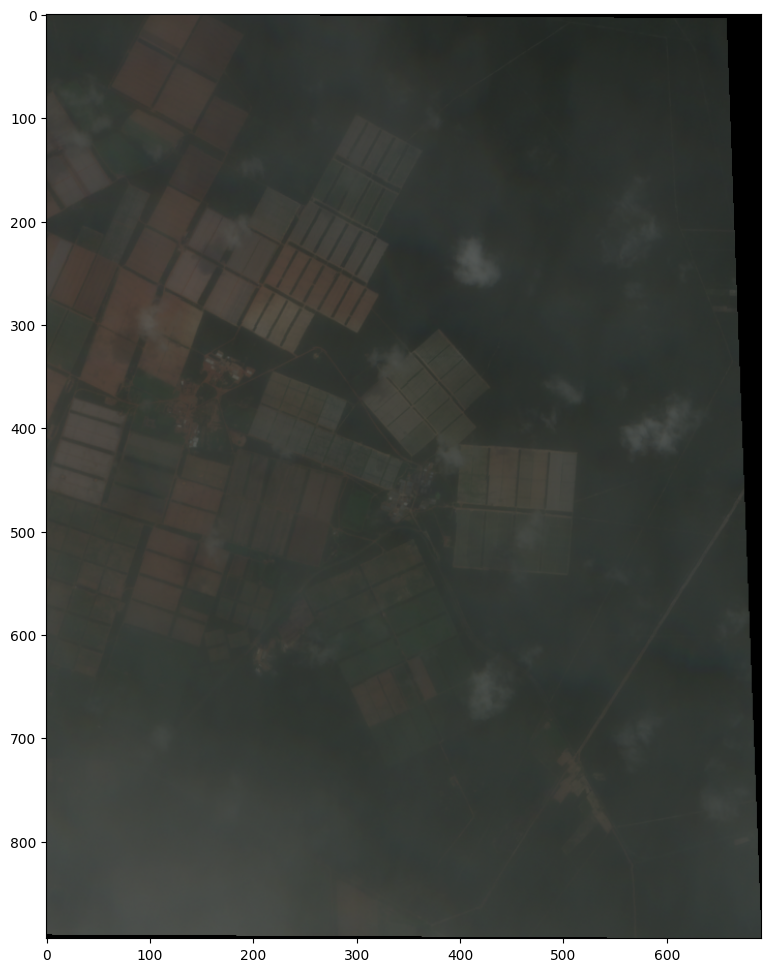

In [ ]:
# Visualize random train image
plt.figure(figsize=[12,12])
plt.imshow(random.choice(train_images))

In [ ]:
img = train_images[0]

print(f"img shape : {np.shape(img)}")
print(f"img type: {type(img)}")

img shape : (894, 692, 3)
img type: <class 'numpy.ndarray'>


In [ ]:
# red
img[..., 0].min()
img[..., 0].max()
# green
img[..., 1].min()
img[..., 1].max()
# blue
img[..., 2].min()
img[..., 2].max()

1.0

# 05- Typical CNN Architecture


Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

## Which architecture is the best for cloud detection?
The choice of the best Convolutional Neural Network (CNN) for cloud detection in remote sensing images depends on several factors, including the complexity of the task, the size and quality of the dataset, computational resources, and the specific goals of your project. However, some CNN architectures have been particularly effective in cloud detection:

### 1. **U-Net**
   - **Advantages:** U-Net is a popular choice for cloud detection due to its symmetric encoder-decoder architecture, which is highly effective for segmentation tasks. The skip connections help in retaining spatial information, making it suitable for precise cloud boundary detection.
   - **Use Case:** U-Net is widely used for semantic segmentation tasks in remote sensing, including cloud detection. It's particularly useful when you need to identify and segment clouds accurately.

### 2. **DeepLabv3+**
   - **Advantages:** DeepLabv3+ incorporates atrous convolutions and a decoder module, making it highly effective in capturing multi-scale contextual information. This is beneficial for detecting clouds at different scales and resolutions.
   - **Use Case:** Suitable for tasks requiring high accuracy in segmentation and boundary delineation, especially in complex scenes with varying cloud densities.

### 3. **ResNet (with Fully Convolutional Networks)**
   - **Advantages:** ResNet, when adapted to a fully convolutional network (FCN), can be effective for cloud detection due to its deep architecture, which allows for better feature extraction. The residual connections help mitigate the vanishing gradient problem, enabling the network to learn better with deeper layers.
   - **Use Case:** Best for tasks where you need a balance between depth and computational efficiency, and when you have access to a large amount of labeled data.

### 4. **SegNet**
   - **Advantages:** SegNet is another encoder-decoder architecture that uses max-pooling indices for upsampling, which helps in maintaining the spatial resolution of the segmentation output. It's less memory-intensive compared to other models like U-Net.
   - **Use Case:** Effective for cloud detection in scenarios where computational resources are limited.

### 5. **DenseNet (with FCN)**
   - **Advantages:** DenseNet, with its dense connectivity pattern, ensures maximum information flow between layers, which can be beneficial for capturing fine-grained details in cloud structures.
   - **Use Case:** Useful in applications where detailed feature extraction is crucial, and the dataset is sufficiently large to benefit from the dense connections.

### 6. **HRNet**
   - **Advantages:** HRNet maintains high-resolution representations throughout the network, making it particularly good at tasks requiring detailed spatial resolution, like cloud detection.
   - **Use Case:** Best suited for tasks requiring high-resolution output, especially in complex environments with fine-scale cloud features.

### 7. **MobileNetV3 (with DeepLabv3)**
   - **Advantages:** For applications requiring deployment on resource-constrained devices, MobileNetV3 combined with DeepLabv3 offers a good trade-off between accuracy and computational efficiency.
   - **Use Case:** Ideal for edge computing scenarios where cloud detection needs to be performed on mobile or low-power devices.

### Recommendations:
- **U-Net** or **DeepLabv3+** are often the top choices for cloud detection due to their strong performance in segmentation tasks.
- If computational resources are limited, consider **SegNet** or **MobileNetV3**.
- If high-resolution detection is critical, **HRNet** is a strong candidate.

The best choice will ultimately depend on your specific dataset, the computational resources available, and the requirements of your project. It might also be beneficial to experiment with a few different architectures and evaluate their performance on your specific cloud detection task.